In [ ]:
# This class is used for Task 2

In [59]:
import datetime

from nltk.app.nemo_app import colors
from tensorflow import keras
from matplotlib import pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import PIL
import numpy as np
from imageio import imread
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.data import AUTOTUNE
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.applications.densenet import layers
import pandas as pd
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Rescaling
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Loads all images to be classified in batch data sets to be processed by the CNN model. 
# No transformation is done here
def load_multiclass_data():
    
    data_dir = pathlib.Path('../dataset/multiclass_tf')

    image_count = len(list(data_dir.glob('*/*.jpg')))
    print('total images')
    print(image_count)

    batch_size = 32
    img_height = 512
    img_width = 512

    train_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        color_mode='grayscale',
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)

    val_ds = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=batch_size)

    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    
    plt.show()
    return train_ds, val_ds

In [16]:
# Resolves imbalances by providing a weight to each class depending on the class count
def class_weights_multiclass(class_names):
    df = pd.read_csv('../dataset/label.csv')
    counts = df['label'].value_counts().to_dict()
    return {
        class_names.index('no_tumor'): counts.get('no_tumor'),
        class_names.index('glioma_tumor'): counts.get('glioma_tumor'),
        class_names.index('meningioma_tumor'): counts.get('meningioma_tumor'),
        class_names.index('pituitary_tumor'): counts.get('pituitary_tumor'),
    }

In [17]:
# Plots metrics over time, extracted from the history provided by tensorflow. Most metrics don't apply for multi
# class except for loss however more exist to track for binary classification
def plot_metrics(history):
    metrics = ['loss']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

    plt.show()


total images
3000
454
0
Found 3000 files belonging to 4 classes.
Using 2400 files for training.
Found 3000 files belonging to 4 classes.
Using 600 files for validation.


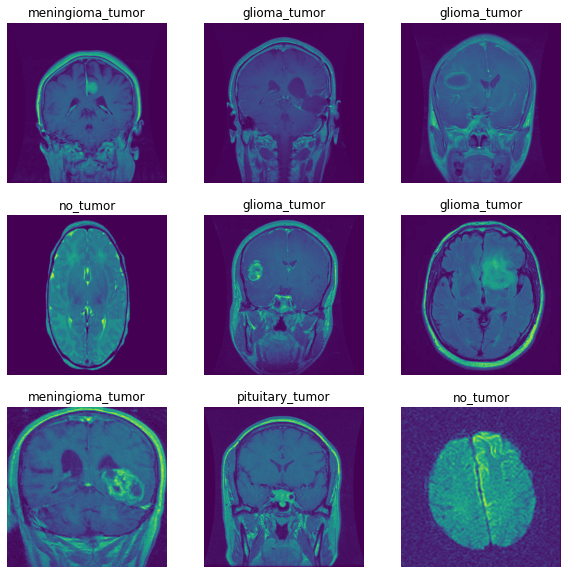

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 512, 512, 16)      416       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 42, 42, 64)       

2021-12-17 10:58:47.251025: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-17 10:58:47.251037: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-17 10:58:47.251768: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


 1/75 [..............................] - ETA: 12:12 - loss: 1091.9708 - accuracy: 0.2812

2021-12-17 10:58:57.222916: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-17 10:58:57.222930: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/75 [..............................] - ETA: 3:41 - loss: 1080.2073 - accuracy: 0.2969 

2021-12-17 10:59:00.249729: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-17 10:59:00.260943: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-17 10:59:00.275343: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20211217-105847/train/plugins/profile/2021_12_17_10_59_00
2021-12-17 10:59:00.292306: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20211217-105847/train/plugins/profile/2021_12_17_10_59_00/Josss-MBP.trace.json.gz
2021-12-17 10:59:00.306363: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20211217-105847/train/plugins/profile/2021_12_17_10_59_00
2021-12-17 10:59:00.306592: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20211217-105847/train/plugins/profile/2021_12_17

75/75 [==============================] - 261s 3s/step - loss: 922.2272 - accuracy: 0.4706 - val_loss: 0.9185 - val_accuracy: 0.6217
Epoch 2/20
75/75 [==============================] - 270s 4s/step - loss: 556.1837 - accuracy: 0.7005 - val_loss: 0.5526 - val_accuracy: 0.7750
Epoch 3/20
75/75 [==============================] - 270s 4s/step - loss: 245.1781 - accuracy: 0.8642 - val_loss: 0.4003 - val_accuracy: 0.8633
Epoch 4/20
75/75 [==============================] - 266s 4s/step - loss: 116.6372 - accuracy: 0.9434 - val_loss: 0.3555 - val_accuracy: 0.8933
Epoch 5/20
75/75 [==============================] - 266s 4s/step - loss: 54.2781 - accuracy: 0.9767 - val_loss: 0.3836 - val_accuracy: 0.8883
Epoch 6/20
75/75 [==============================] - 266s 4s/step - loss: 64.2742 - accuracy: 0.9707 - val_loss: 0.4131 - val_accuracy: 0.8883
Epoch 7/20
75/75 [==============================] - 266s 4s/step - loss: 21.9973 - accuracy: 0.9937 - val_loss: 0.3924 - val_accuracy: 0.8967
Epoch 8/20
75

In [18]:
train_ds, val_ds = load_multiclass_data()
class_names = train_ds.class_names

# Caches the images to improve training performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(512, 512, 1)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

# Stores logs to be utilised by tensorboard for visualisation of progress
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback],
    class_weight=class_weights_multiclass(class_names)
)

{'verbose': 1, 'epochs': 20, 'steps': 75}


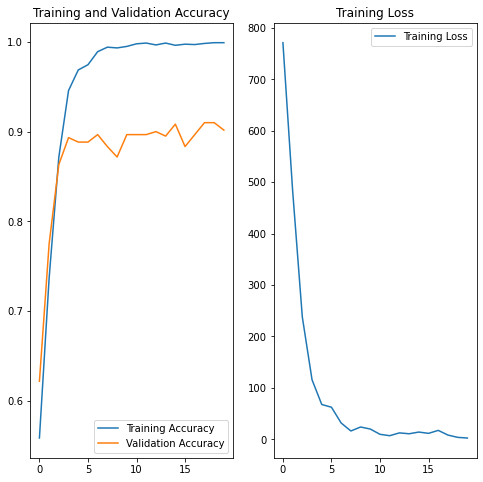

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [72]:
# Extracts the test data provided in final week to validate the model with a new dataset
def extract_test_data():
    df = pd.read_csv('../dataset/raw/test/label.csv')

    X = []
    for index, row in df.iterrows():
        img_gray = imread('../dataset/raw/test/image/' + row['file_name'], as_gray=True)
        X.append(img_gray)
    return X

def get_class_index(x):
    return class_names.index(x)


X = extract_test_data()
X = tf.expand_dims(X, axis=-1)
Y = pd.read_csv('../dataset/raw/test/label.csv')

Y_predicted = model.predict_classes(X)

Y = np.vectorize(get_class_index)(Y['label'].to_numpy())

print('Accuracy on CNN test set: ' + str(accuracy_score(Y, Y_predicted)))
print(classification_report(Y, Y_predicted))

/Users/jossmt/anaconda2/envs/MachineLearningUcl/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Accuracy on CNN test set: 0.86
              precision    recall  f1-score   support

           0       0.80      0.81      0.80        43
           1       0.91      0.78      0.84        68
           2       0.86      0.86      0.86        37
           3       0.85      1.00      0.92        52

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200

